##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/model_maker_image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

The [TensorFlow Lite Model Maker library](https://www.tensorflow.org/lite/guide/model_maker) simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications.

This notebook shows an end-to-end example that utilizes this Model Maker library to illustrate the adaption and conversion of a commonly-used image classification model to classify flowers on a mobile device.

## Prerequisites

To run this example, we first need to install several required packages, including Model Maker package that in GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [ ]:
!python -m pip install -q tflite-model-maker

You should consider upgrading via the 'C:\Users\nzwen\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Import the required packages.

In [ ]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

print("\u2022 Using TensorFlow Version:", tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.6.0
• GPU Device Found.


## Detailed Process

Currently, we support several models such as  EfficientNet-Lite* models, MobileNetV2, ResNet50 as pre-trained models for image classification. But it is very flexible to add new pre-trained models to this library with just a few lines of code.


The following walks through this end-to-end example step by step to show more detail.

### Step 1: Load Input Data Specific to an On-device ML App

The flower dataset contains 2510 images belonging to 5 classes. Download the archive version of the dataset and untar it.

The dataset has the following directory structure:

<pre>
<b>Massey Combined Dataset</b>
|__ <b>0</b>
    |______ hand1_0_bot_seg_1_cropped.jpg
    |______ hand1_0_bot_seg_2_cropped.jpg
    |______ ...
|__ <b>1</b>
    |______ hand1_1_bot_seg_1_cropped.jpg
    |______ hand1_1_bot_seg_2_cropped.jpg
    |______ ...
|__ <b>...</b>
    |______ ...
    |______ ...
    |______ ...
|__ <b>y</b>
    |______ hand1_y_bot_seg_1_cropped.jpg
    |______ hand1_y_bot_seg_2_cropped.jpg
    |______ ...
|__ <b>z</b>
    |______ hand1_z_bot_seg_1_cropped.jpg
    |______ hand1_z_bot_seg_2_cropped.jpg
    |______ ...
</pre>

In [ ]:
import pathlib
image_path = pathlib.Path("C:/Dev/Massey Dataset/Massey Combined Dataset")
print(image_path)

C:\Dev\Massey Dataset\Massey Combined Dataset


You could replace `image_path` with your own image folders. As for uploading data to colab, you could find the upload button in the left sidebar shown in the image below with the red rectangle. Just have a try to upload a zip file and unzip it. The root file path is the current path.

<img src="https://storage.googleapis.com/download.tensorflow.org/models/tflite/screenshots/model_maker_image_classification.png" alt="Upload File" width="800" hspace="100">

Use `DataLoader` class to load data.

As for `from_folder()` method, it could load data from the folder. It assumes that the image data of the same class are in the same subdirectory and the subfolder name is the class name. Currently, JPEG-encoded images and PNG-encoded images are supported.

In [ ]:
data = DataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 2510, num_label: 36, labels: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z.


Split it to training data (80%), validation data (10%, optional) and testing data (10%).

In [ ]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

Show 25 image examples with labels.

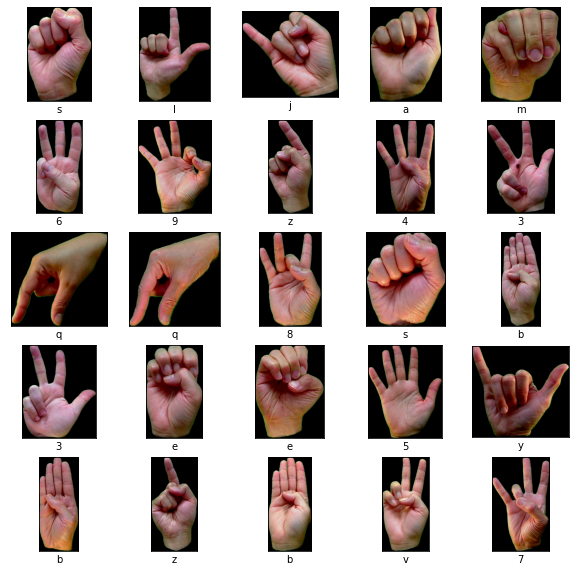

In [ ]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

### Step 2: Customize the TensorFlow Model

Create a custom [image classifier model](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/image_classifier/create) based on the loaded data. The default model is EfficientNet-Lite0.


In [ ]:
model = image_classifier.create(train_data, model_spec=model_spec.get('efficientnet_lite4'), validation_data=validation_data, shuffle=True, epochs=100)

INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              11837936  
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 36)                46116     
Total params: 11,884,052
Trainable params: 46,116
Non-trainable params: 11,837,936
_________________________________________________________________
None


c:\users\nzwen\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
62/62 [==============================] - 42s 516ms/step - loss: 3.3486 - accuracy: 0.1346 - val_loss: 2.9329 - val_accuracy: 0.3304
Epoch 2/100
62/62 [==============================] - 33s 533ms/step - loss: 2.7082 - accuracy: 0.4002 - val_loss: 2.4910 - val_accuracy: 0.5223
Epoch 3/100
62/62 [==============================] - 35s 564ms/step - loss: 2.3663 - accuracy: 0.5368 - val_loss: 2.2267 - val_accuracy: 0.5938
Epoch 4/100
62/62 [==============================] - 38s 609ms/step - loss: 2.1472 - accuracy: 0.6230 - val_loss: 2.0386 - val_accuracy: 0.7009
Epoch 5/100
62/62 [==============================] - 39s 632ms/step - loss: 1.9947 - accuracy: 0.6704 - val_loss: 1.9086 - val_accuracy: 0.7143
Epoch 6/100
62/62 [==============================] - 41s 662ms/step - loss: 1.8759 - accuracy: 0.7077 - val_loss: 1.7977 - val_accuracy: 0.7857
Epoch 7/100
62/62 [==============================] - 44s 716ms/step - loss: 1.7841 - accuracy: 0.7399 - val_loss: 1.7223 - val_accuracy:

Have a look at the detailed model structure.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              11837936  
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 36)                46116     
Total params: 11,884,052
Trainable params: 46,116
Non-trainable params: 11,837,936
_________________________________________________________________


### Step 3: Evaluate the Customized Model

Evaluate the result of the model, get the loss and accuracy of the model.

In [ ]:
loss, accuracy = model.evaluate(test_data)

8/8 [==============================] - 6s 549ms/step - loss: 1.0311 - accuracy: 0.9442


We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

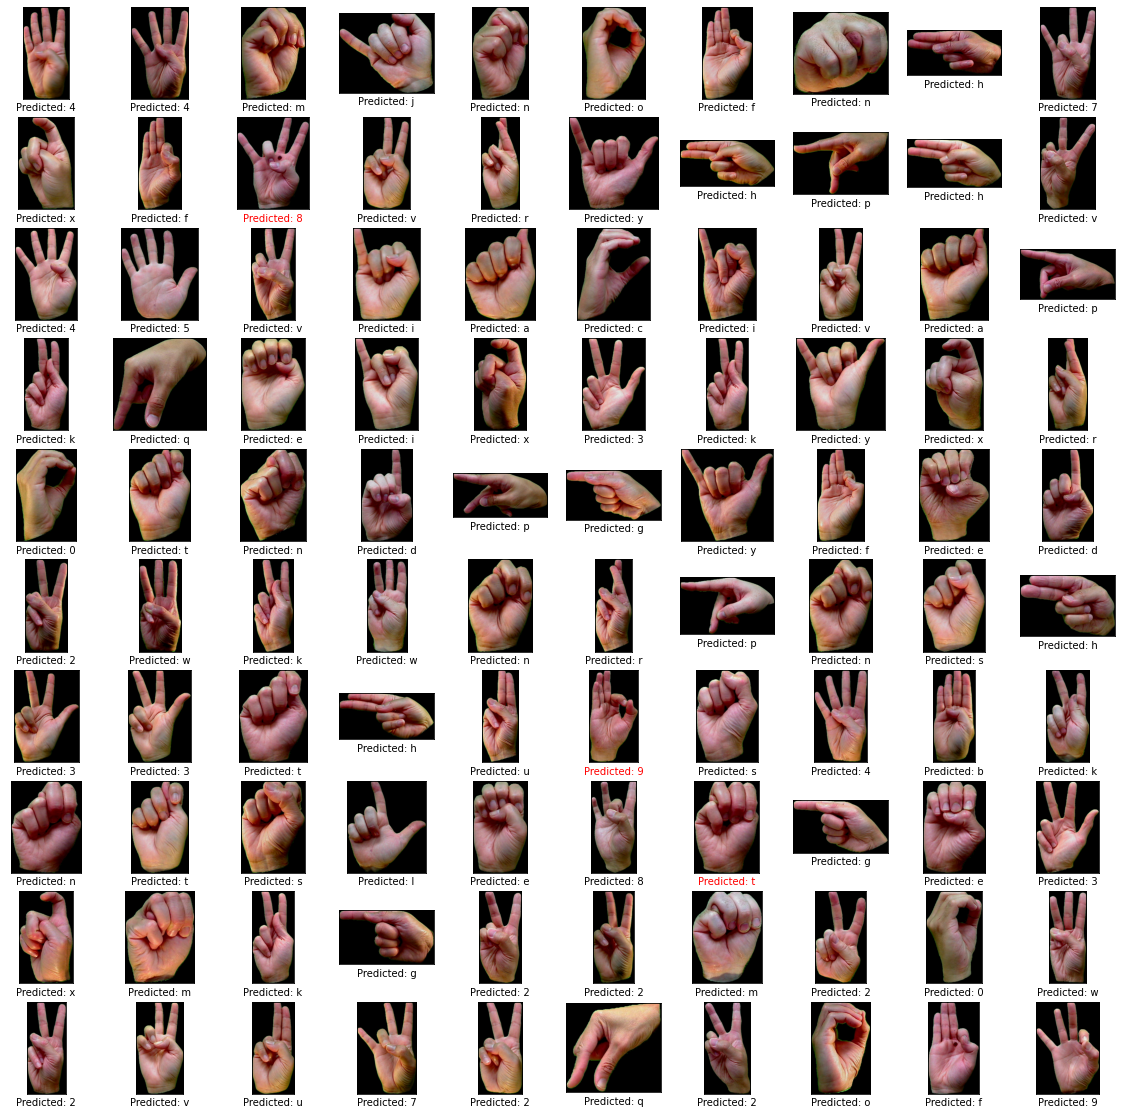

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

If the accuracy doesn't meet the app requirement, one could refer to [Advanced Usage](#scrollTo=zNDBP2qA54aK) to explore alternatives such as changing to a larger model, adjusting re-training parameters etc.

### Step 4: Export to TensorFlow Lite Model

Convert the trained model to TensorFlow Lite model format with [metadata](https://www.tensorflow.org/lite/convert/metadata) so that you can later use in an on-device ML application. The label file and the vocab file are embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster.
The default post-training quantization technique is full interger quantization for the image classification task.

In [ ]:
export_dir="C:/Dev/TensorFlow Model/KestrelModel_EfficientNet-Lite4_1"

In [ ]:
model.export(export_dir)

INFO:tensorflow:Assets written to: C:\Users\nzwen\AppData\Local\Temp\tmpmzrzvyxj\assets


INFO:tensorflow:Assets written to: C:\Users\nzwen\AppData\Local\Temp\tmpmzrzvyxj\assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in C:\Users\nzwen\AppData\Local\Temp\tmp91_6vwsf\labels.txt


INFO:tensorflow:Saving labels in C:\Users\nzwen\AppData\Local\Temp\tmp91_6vwsf\labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: C:/Dev/TensorFlow Model/KestrelModel_EfficientNet-Lite4_1\model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: C:/Dev/TensorFlow Model/KestrelModel_EfficientNet-Lite4_1\model.tflite


See [example applications and guides of image classification](https://www.tensorflow.org/lite/models/image_classification/overview#example_applications_and_guides) for more details about how to integrate the TensorFlow Lite model into mobile apps.

This model can be integrated into an Android or an iOS app using the [ImageClassifier API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

The allowed export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`

By default, it just exports TensorFlow Lite model with metadata. You can also selectively export different files. For instance, exporting only the label file as follows:

In [ ]:
model.export(export_dir, export_format=ExportFormat.LABEL)

INFO:tensorflow:Saving labels in C:/Dev/TensorFlow Model/KestrelModel_EfficientNet-Lite4_1\labels.txt


INFO:tensorflow:Saving labels in C:/Dev/TensorFlow Model/KestrelModel_EfficientNet-Lite4_1\labels.txt


In [ ]:
model.export(export_dir, export_format=ExportFormat.SAVED_MODEL)

INFO:tensorflow:Assets written to: C:/Dev/TensorFlow Model/KestrelModel_EfficientNet-Lite4_1\saved_model\assets


INFO:tensorflow:Assets written to: C:/Dev/TensorFlow Model/KestrelModel_EfficientNet-Lite4_1\saved_model\assets


You can also evaluate the tflite model with the `evaluate_tflite` method.

In [ ]:
from tensorflow import keras
model = keras.models.load_model("C:/Dev/TensorFlow Model/KestrelModel_EfficientNet-Lite4_1/saved_model")

In [ ]:
model.evaluate_tflite("C:/Dev/TensorFlow Model/KestrelModel_EfficientNet-Lite4_1/model.tflite", test_data)

## Advanced Usage

The `create` function is the critical part of this library. It uses transfer learning with a pretrained model similar to the [tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).

The `create` function contains the following steps:

1.   Split the data into training, validation, testing data according to parameter `validation_ratio` and `test_ratio`. The default value of `validation_ratio` and `test_ratio` are `0.1` and `0.1`.
2.   Download a [Image Feature Vector](https://www.tensorflow.org/hub/common_signatures/images#image_feature_vector) as the base model from TensorFlow Hub. The default pre-trained model is  EfficientNet-Lite0.
3.   Add a classifier head with a Dropout Layer with `dropout_rate` between head layer and pre-trained model. The default `dropout_rate` is the default `dropout_rate` value from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub.
4.   Preprocess the raw input data. Currently, preprocessing steps including normalizing the value of each image pixel to model input scale and resizing it to model input size.   EfficientNet-Lite0 have the input scale `[0, 1]` and the input image size `[224, 224, 3]`.
5.   Feed the data into the classifier model. By default, the training parameters such as training epochs, batch size, learning rate, momentum are the default values from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub. Only the classifier head is trained.


In this section, we describe several advanced topics, including switching to a different image classification model, changing the training hyperparameters etc.


## Customize Post-training quantization on the TensorFLow Lite model


[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.


Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

In [ ]:
config = QuantizationConfig.for_float16()

Then we export the TensorFlow Lite model with such configuration.

In [ ]:
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)

In Colab, you can download the model named `model_fp16.tflite` from the left sidebar, same as the uploading part mentioned above.

## Change the model


### Change to the model that's supported in this library.

This library supports  EfficientNet-Lite models, MobileNetV2, ResNet50 by now. [EfficientNet-Lite](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite) are a family of image classification models that could achieve state-of-art accuracy and suitable for Edge devices. The default model is EfficientNet-Lite0.

We could switch model to MobileNetV2 by just setting parameter `model_spec` to the MobileNetV2 model specification in `create` method.

In [ ]:
model = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data)

Evaluate the newly retrained MobileNetV2 model to see the accuracy and loss in testing data.

In [ ]:
loss, accuracy = model.evaluate(test_data)

### Change to the model in TensorFlow Hub

Moreover, we could also switch to other new models that inputs an image and outputs a feature vector with TensorFlow Hub format.

As [Inception V3](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1) model as an example, we could define `inception_v3_spec` which is an object of [image_classifier.ModelSpec](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/image_classifier/ModelSpec) and contains the specification of the Inception V3 model.

We need to specify the model name `name`, the url of the TensorFlow Hub model `uri`. Meanwhile, the default value of `input_image_shape` is `[224, 224]`. We need to change it to `[299, 299]` for Inception V3 model.

In [ ]:
inception_v3_spec = image_classifier.ModelSpec(
    uri='https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1')
inception_v3_spec.input_image_shape = [299, 299]

Then, by setting parameter `model_spec` to `inception_v3_spec` in `create` method, we could retrain the Inception V3 model.

The remaining steps are exactly same and we could get a customized InceptionV3 TensorFlow Lite model in the end.

### Change your own custom model

If we'd like to use the custom model that's not in TensorFlow Hub, we should create and export [ModelSpec](https://www.tensorflow.org/hub/api_docs/python/hub/ModuleSpec) in TensorFlow Hub.

Then start to define `ModelSpec` object like the process above.

## Change the training hyperparameters
We could also change the training hyperparameters like `epochs`, `dropout_rate` and `batch_size` that could affect the model accuracy. The model parameters you can adjust are:


*   `epochs`: more epochs could achieve better accuracy until it converges but training for too many epochs may lead to overfitting.
*   `dropout_rate`: The rate for dropout, avoid overfitting. None by default.
*   `batch_size`: number of samples to use in one training step.  None by default.
*   `validation_data`: Validation data. If None, skips validation process. None by default.
*   `train_whole_model`: If true, the Hub module is trained together with the classification layer on top. Otherwise, only train the top classification layer. None by default.
*   `learning_rate`: Base learning rate. None by default.
*   `momentum`: a Python float forwarded to the optimizer. Only used when
      `use_hub_library` is True. None by default.
*   `shuffle`: Boolean, whether the data should be shuffled. False by default.
*   `use_augmentation`: Boolean, use data augmentation for preprocessing. False by default.
*   `use_hub_library`: Boolean, use `make_image_classifier_lib` from tensorflow hub to retrain the model. This training pipeline could achieve better performance for complicated dataset with many categories. True by default. 
*   `warmup_steps`: Number of warmup steps for warmup schedule on learning rate. If None, the default warmup_steps is used which is the total training steps in two epochs. Only used when `use_hub_library` is False. None by default.
*   `model_dir`: Optional, the location of the model checkpoint files. Only used when `use_hub_library` is False. None by default.

Parameters which are None by default like `epochs` will get the concrete default parameters in [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/02ab9b7d3455e99e97abecf43c5d598a5528e20c/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L54) from TensorFlow Hub library or  [train_image_classifier_lib](https://github.com/tensorflow/examples/blob/f0260433d133fd3cea4a920d1e53ecda07163aee/tensorflow_examples/lite/model_maker/core/task/train_image_classifier_lib.py#L61).

For example, we could train with more epochs.


In [ ]:
model = image_classifier.create(train_data, validation_data=validation_data, epochs=10)

Evaluate the newly retrained model with 10 training epochs.

In [ ]:
loss, accuracy = model.evaluate(test_data)

# Read more

You can read our [image classification](https://www.tensorflow.org/lite/examples/image_classification/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/guide/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ImageClassifier](https://www.tensorflow.org/lite/inference_with_metadata/task_library/image_classifier) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification/raspberry_pi).

